In [1]:
import pandas as pd
import json
from ast import literal_eval
import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import community as community_louvain
from itertools import combinations
import re
from nltk import word_tokenize
import seaborn as sns

In [2]:
def Plot(Samples, Names, color,numbins):
    fig, ax = plt.subplots(1,1)
    sns.set_style("darkgrid")
     
    MAX = np.max(Samples)
    MIN = np.min(Samples)
    bins = np.linspace(MIN,MAX,numbins)
    hist, edges = np.histogram (Samples, bins = bins, density = False)
    x = (edges[1:]+edges[:-1])/2
    width = bins[1]-bins[0]


    ax.bar(x, hist, width = width*0.9, color =  color)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(Names)
    
    plt.show()
    return

### Function for data cleaning

In [3]:
def CleanData(data): 
    
    """
    input: dataframe with columns: season, episode, geographical location, text
    
    returns: cleaned dataframe with same columns
    """
    # remove "recap" secitons
    IndicesToBeRemoved = data.index[data['geo'] == 'Recap'].tolist()
    data = data.drop(IndicesToBeRemoved, axis=0)   

    # Get on list form 
    data['text']  = [literal_eval(l) for l in data.text]

    # remove newline
    for i in range(len(data)):
        text = data['text'].iloc[i]

        # remove newline
        text = [t.strip() for t in text]

        # split in non-sign tokens
        tokens = []
        for t in text: 
            tokens = tokens + re.split(r'\W', t)

        # join tokens 
        text = ' '.join(tokens)
        text = text.replace(' s ', ' ')
        text = text.replace('  ', ' ')

        data['text'].iloc[i] = text
    
    return data

### Function for characternames loading

In [4]:
def CharacterNames(path):
    """
    input: path to json
    returns: list of character names 
    """
    
    CN = []
    with open(path) as json_file:
        data = json.load(json_file)
        for p in data['characters']:
            CN.append(p['characterName'])

    removes = []
    for name in CN: 
        if "Little Bird" in name or 'Great Master' in name or "Night's" in name or "White Walker" in name or 'Musician' in name or "Winterfell" in name:
            removes.append(name)
        if "Guard" in name or "Bloodrider" in name or "Goldcloak" in name or "King's Landing Rioter" in name or "Dwarf" in name or "Old Man" in name:
            removes.append(name)
            
        if "Bannerman" in name or "Young" in name or "Lannister Captain" in name or "Lannister Captain" in name or "Wedding" in name or 'Ghost' in name:
            removes.append(name)
        
        if "Lannister Messenger" in name or "Lannister Scout" in name or "Nymeria Sand" in name: 
            removes.append(name)
            

    removes.append("Lady")

    CN = [name for name in CN if name not in removes] 

    CN = CN + ['Varys', "The Mountain", "Selyse Florent" , "Littlefinger",
                                     "Wun Weg Wun Dar Wun", "Harrag", "Archmaester Ebrose", "The High Sparrow", 'Dany']
    
    CN = np.array(CN)
    CN[CN == 'Ramsay Snow'] = 'Ramsay Snow/Bolton'
    
    return CN


# Method for findind connected characters
#### Characters who appears in same geographical location in same episode.

In [5]:
def GetFullyConnectedSubgraps(data, CN, n1, nh): 
    
    """
    input: data: data with season, episode, geo and text. 
           CN: list of characternames
           n1, nh: character specific information (n1: keep 2. name, nh: keep full name)
           
    returns: dict with (season, episode, geo) as key and names of characters connected via info from key
             and list of name triplets (name to search for, name to search for minus space, full name)
    """
    
    # Get connections
    Connections = {}
    NewCN = []
    for _,row in data.iterrows(): #all texts 
        TextEdges = []

        for name in CN: #all names 
            n = name

            # first name 
            if ' ' in name:
                fn = re.split(r'\W', name)[0] #first name 
                ln = re.split(r'\W', name)[1] #last name

                if fn in nh or ln == 'of': 
                    n = name

                elif fn in n1: 
                    n = ln          
                else:
                    n = fn

            else: 
                pass

            if n in row['text']:  #check if name in text 
                TextEdges.append(name)
                if (n, n.replace(" ", ""), name) not in NewCN: 
                    NewCN.append((n, n.replace(" ", ""), name))

        # Store connection 
        Connections[(row['season'],row['episode'], row['geo'])] = set(TextEdges)
       
    return Connections, NewCN


# Structure connected characters in a dataframe

In [6]:
def NamesDf(Connections, save = False):
    """
    input: Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
           save: True if dataframe is to be saved
           
    returns: Dataframe with index = characternames and content = connections and season, episode and geo for connection
    """
    
    #  Initialise new dataframe
    Names = pd.DataFrame(columns = ['name'], data = CN)
    Names['ConnectedTwo'] = [None]*len(CN)

    # Create list of connections for each character
    for _, row in Names.iterrows():
        c = []
        for key, val in Connections.items(): 
            if row['name'] in val: 
                c.append((key, val))

        row['ConnectedTwo'] = c

    Names.index = Names['name']
    del Names['name']


    # Merge nicknames and names
    # Daenerys Targaryen
    dany = Names.loc['Dany', 'ConnectedTwo'] + Names.loc['Daenerys Targaryen', 'ConnectedTwo']
    if len(dany) == 133: 
        Names.loc['Daenerys Targaryen'].ConnectedTwo = dany

    # Store in csv
    if save: 
        Names.to_csv('Names.csv')
        
    return Names

# Methods for finding weights and links

In [7]:
def NodeWeight(text, CN):
    """
    input: text: String 
    input: CN: List of tripplets with names (name to search for, name to search for minus space, full name)
    returns: count_dict: frequency of names in text
    """
    
    CN0 = [i for i,_,_ in CN]
    CN1 = [i for _,i,_ in CN]
    CN2 = [i for _,_,i in CN]

    #remove space in names of interest 
    for cn0, cn1 in zip(CN0, CN1):
        text = text.replace(cn0, cn1)
        
    # Tokenize
    tokens = word_tokenize(text)
        
    count_dict = {name: 0 for name in CN2}
    
    for word in tokens:
        if word in CN1:
            
            idx = CN1.index(word)
            count_dict[CN2[idx]] = count_dict[CN2[idx]] + 1
            
    return count_dict

In [8]:
def GetEdges(Connections): 
    
    """
    input: Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
    
    returns: set of edges
    """
    
    # Get all edges
    Edges = []
    for g in Connections.values(): 
        Edges += [i for i in combinations(g, 2)] #for each fully connected subgraph, add all links in that graph 

    # Remove double. tripple etc. edges 
    Edges = [tuple(sorted(edge)) for edge in Edges]
    Edges = set(Edges)
    
    return Edges

In [9]:
def GetLinkWeights(Edges, Connections):
    
    """
    input: Edges: Set of Edges
           Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
           
    returns: WeightsInput: list of triplets each with a pair of connected nodes as well as the link weight. 
    """
    
    Weights = {edge: 0 for edge in Edges}
    for edge in Weights.keys(): 
        w = 0
        for s in Connections.values(): 
            if (edge[0] in s) and (edge[1] in s): 
                w +=1
        Weights[edge] = w

    WeightsInput = [(key[0],key[1], {'weight': val}) for key, val in Weights.items()] 
    
    return WeightsInput

In [10]:
def Cutoff(G, a, b, c, link_weight, GetMinWeightCutOff = False, GetDegCutOff = False, GetNodeSize = False): 
    """
    input: Graph
           a: min link weight
           b: min number of degrees in node
           c: min node size
           GetMinWeightCutOff, GetDegCutOff: Booleans
    output: Nodes and/or links to be removed
    """
    DelNodeSize, DelNodeDeg, DelEdge = [], [], []
    # Weight cut off: 
    if GetMinWeightCutOff:
        for name1, name2, d in link_weight: 
            if int(d['weight']) < a: 
                DelEdge.append((name1,name2))
            

    # Node cutof based on degree: 
    if GetDegCutOff: 
        for key, val in dict(G_W.degree()).items(): 
            if val < b: 
                DelNodeDeg.append(key)
                
                 
    # Weight Distribution
    if GetNodeSize:
        for node in G_W.nodes:
            if G_W.nodes[node]["size"] < c:
                DelNodeSize.append(node)
                
    for e in DelEdge:
        G_W.remove_edge(e[0], e[1])

    for n in DelNodeDeg: 
        G_W.remove_node(n)
        
    for n in DelNodeSize: 
        G_W.remove_node(n)

    return G_W, DelNodeSize, DelNodeDeg, DelEdge


def ZeroDegCutOff(G): 
    """
    input: Graph
    """
    
    # Nodes with zero degree: 
    Del = []
    for name, d in G.degree():
        if d == 0: 
            Del.append(name)
            
    for name in Del: 
        G.remove_node(name)
        
    return G





# Weighted graph method

In [11]:
# Join all text

def WeightedGraph(data, Connections, NewCN): 
    
    """
    input: Connections:  dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text            
           
    returns: Weighted graph.
             link_weight: weight of links. Used for cutof outside function
             
    """
    
    #Join text 
    alltext = ' '.join(data.text.values)
    
    # Compute node weights
    node_weight = NodeWeight(alltext, NewCN)
    
    # Find links: 
    Edges = GetEdges(Connections)
    
    # Compute link weight
    link_weight = GetLinkWeights(Edges, Connections)
    
    # Initialise weighted graph: 
    G_W = nx.Graph()

    # Add nodes
    G_W.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None, size = None)

    # Add node size (weight)
    for key, val in node_weight.items(): 
        G_W.nodes[key]['size'] = val

    # Add links and weights
    G_W.add_edges_from(link_weight)
    
        
    # Remove nodes with zero degree
    G_W = ZeroDegCutOff(G_W)
    
    return G_W, link_weight
    

# Unweighted graph method

In [12]:
def UnweightedGraph(Connections):
    
    # Compute links: 
    Edges = GetEdges(Connections)

    #Initialise
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None)

    # Add edges to graph 
    G.add_edges_from(Edges)  
    
    # Remove nodes with zero degee
    G = ZeroDegCutOff(G)
    
    return G

# Modularity

In [13]:
def GraphModularity(graph, p):
    """
    input: graph: networkX graph or list of nodes and attributes
           p: Partition definer: list containing attribute dict key and tuple with attribute dict values
           
    return: Modularity of graph
    """
    #Number of links in graph: 
    L = len(graph.edges())

    M = 0
    key = p[0] #
    p = p[1]
    deg = {i:0 for i in p}
    links = {i:0 for i in p}

    # loop through graph nodes: 
    for node in graph: 
        par = graph.nodes[node][key] # node partition 
        deg[par] += graph.degree[node] # node degree

        l = sum([w.get(weight, 1)/2 for n,w in graph[node].items() if graph.nodes[node][key] == graph.nodes[n][key]])

        links[par] += l


    for par in p: 
        M += links[par]/L - (deg[par]/(2*L))**2

    return M

# Prepare data

In [14]:
# Load character names: 
path = 'characters.json'
CN = CharacterNames(path)

# Load data
data = pd.read_csv('GOT.csv')

# Clean data 
data = CleanData(data)  

# Names with need for special treatment
n1 = ["Archmaester", "Baby", "Barristan", "Captain", "Khal"]
nh = ["Black", "Brother", "Child", "Grey", "High", "Knight" , "Robert", "Rickard", "Three-eyed", "The", "Wun", "Will", "Lord", "Jon", "Red", "Maester", "Ser", "Lyanna", "Lady", 
     "Grand", "Old", "Septa", "Hot", "Thin", "Lem", "Selyse", "Nymeria", "Arthur", "Jaqen", "Margaery"]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs incl. all seasons

### Weighted graph:

In [126]:
# Retrieve info of who is connected
Connections, NewCN = GetFullyConnectedSubgraps(data, CN, n1, nh)

G_W, link_weight = WeightedGraph(data, Connections, NewCN)

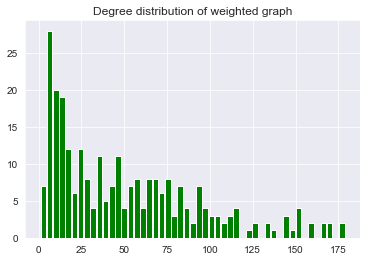

In [127]:
# Degree distribution
degreedist = [d for _,d in G_W.degree()]
Plot(degreedist, "Degree distribution of weighted graph", "green", 50)

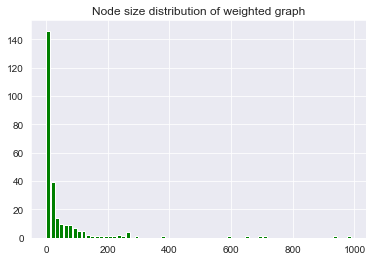

In [128]:
# Size distribution
sizedist = [val['size'] for val in dict(G_W.nodes.data()).values()]
Plot(sizedist, "Node size distribution of weighted graph", "green", 70)

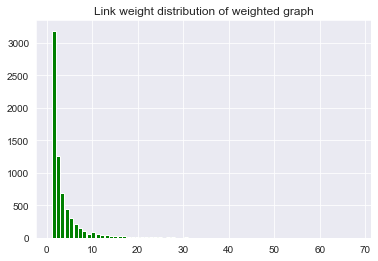

In [129]:
# Weight distribution
weightdist = [w['weight'] for _, _, w in link_weight]
Plot(weightdist, "Link weight distribution of weighted graph", "green", 70)

In [130]:
# Remove nodes and edges based on cutoffs   
a = 1
b = 0
c = 2
G_W, DelNodeSize, DelNodeDeg, DelEdge = Cutoff(G_W, a, b, c, link_weight, GetMinWeightCutOff = True, GetDegCutOff = True, GetNodeSize = True)

# Remove zero degee nodes 
G_W = ZeroDegCutOff(G_W)

print("Number of nodes in weigthed graph: " + str(len(G_W.nodes())))
print("Number of links in weighted graph: " + str(len(G_W.edges())))

stylized_network, config = nw.visualize(G_W)

Number of nodes in weigthed graph: 239
Number of links in weighted graph: 6548


### Unweighted graph

In [19]:
G = UnweightedGraph(Connections)


print("Number of nodes in unweigthed graph: " + str(len(G.nodes())))
print("Number of links in unweighted graph: " + str(len(G.edges())))

Number of nodes in unweigthed graph: 267
Number of links in unweighted graph: 6884


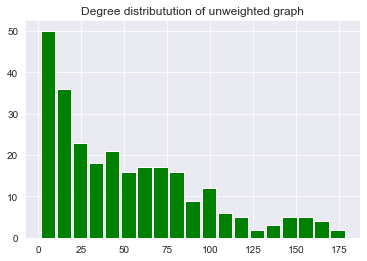

In [20]:
# Plot degree distribution
degreedist = [d for _,d in G.degree()]
Plot(degreedist, "Degree distributution of unweighted graph", "green", 20)

In [21]:
# Remove nodes and edges with nodesize and edge weight cutoff rules from the weighted graph
for e in DelEdge:
    G.remove_edge(e[0], e[1])

for n in DelNodeSize: 
    G.remove_node(n)
    
# Remove zero degree nodes
G= ZeroDegCutOff(G)

print("Number of nodes in unweigthed graph: " + str(len(G.nodes())))
print("Number of links in unweighted graph: " + str(len(G.edges())))

Number of nodes in unweigthed graph: 239
Number of links in unweighted graph: 6548


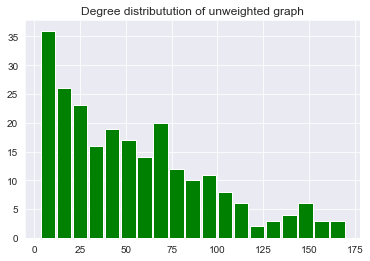

In [22]:
# Plot degree distribution
degreedist = [d for _,d in G.degree()]
Plot(degreedist, "Degree distributution of unweighted graph", "green", 20)

### Partitioning unweighted graph with louvain

In [140]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
for key, val in LouvainCommunities.items(): 
    G.nodes[key]['LouvainPartition'] = val
    G.nodes[key]['group'] = val

#stylized_network, config = nw.visualize(G)

# Modularity of louvain partition
partitioning = ['LouvainPartition', (0, 1, 2, 3)]
GraphModularity(G,partitioning)

0.20706881591286413

# Per season

### Weighted graph

In [24]:
season = "season2"

In [25]:
data1 = data[data["season"] == season]

In [26]:
Connections1, NewCN1 = GetFullyConnectedSubgraps(data1, CN, n1, nh)

G_W1, link_weight1 = WeightedGraph(data1, Connections1, NewCN1)

In [28]:
nx.write_gpickle(G_W1, "Gseason2.gpickle")

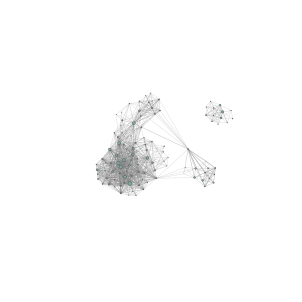

In [27]:
stylized_network, config = nw.visualize(G_W1)

### Unweighted graph 